In [1]:
# Generic Dependencies
import numpy as np
from numpy import arange
import pandas as pd
from pandas import set_option
import math
# from pandas.tools.plotting import scatter_matrix
import os

# Plotting Libraries
from matplotlib import pyplot as plt
import seaborn as sns

# SKLearn Libraries
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, LassoCV, Ridge,RidgeCV
from sklearn.model_selection import cross_validate

# library for saving models
from sklearn.externals import joblib

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

#XGBoost libraries
import xgboost as xgb

# explain xgboost preiction and model
import shap


# import generateXdata.py to prepare the data
# from generateXdata import generateX
from generateXdata import generateX_samp

#Import Custom ml models
from Cls_ml_models import ml_models_tuned


In [2]:
# gobal variables
dataFilePath = "dataforfinalproject"
filename = "sampletest.csv"
cols_file = "Final_Columns_withCat.csv"

sampleFile = "InputSamples.csv"

totsqt_names = {0 : "Any sqft",
             1 : "< 900",
             2 : "Between 900 to 1500",
             3 : "Between 1500 to 2500",
             4 : "Between 2500 to 3500))",
             5 : "Greater than 3500)"}



In [30]:
X, vocab, y = generateX_samp(ohe = True, target = "DOLLAR", numSamples = 200, region = 4, totsqft_cd = 1)

 X Features shape : (200, 87)
y label shape : (200,)
shape of X is (200, 79)


In [ ]:
### pd.DataFrame(X,columns = vocab).to_csv(os.path.join("dataforfinalproject/InputSamples.csv"), index = True)

In [40]:
# df_recs = pd.read_csv(os.path.join(dataFilePath, filename), low_memory= False)


# df_recs[(eval(totsqt[3]))]

# df_recs[(df_recs.REGIONC == 2) & (eval(totsqt[3]))].sample( n = 10)

In [31]:
y

8288     2264.00
19060    1872.11
20709    1039.67
632       873.00
4535     1139.00
17410    1249.00
18330     370.01
19727     577.22
43        929.00
383       610.00
5589      672.00
8455      478.00
11510     931.00
10223    1184.00
12688    1074.00
18785    1983.51
16312    1464.55
5423      955.00
4240     1254.00
3227     1255.00
4024     1416.00
12128    1113.00
1560      412.00
12857     331.00
18942    1130.43
12881    1684.00
4866      452.00
19017    1124.35
13273    1579.00
9266     1327.00
          ...   
12907     639.00
2353      641.00
12352     801.00
7032     1984.00
13762    1357.00
3267      445.00
2737     1730.00
10123     912.00
15678    1342.00
2355      901.00
11103     543.00
21038     730.00
4089      412.00
8108     1337.00
6786      237.00
8559      437.00
17952    1897.14
2167     1377.00
10937    1293.00
6946     1216.00
16210    2964.00
13739     898.00
16265    1016.60
20000    1056.19
14205     896.00
3747      762.00
9042      822.00
7754     1196.

In [32]:
# load the model into a list
model_name = ["Classic Lasso","Elasticnet", "LassoCV", "LR","RF", "RidgeCV","XGB"]
models = [joblib.load(os.path.join("final_models",file)) for file in os.listdir("final_models") if file.endswith("sav")]

In [33]:
models

[Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.003, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
     max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
     positive=False, precompute='auto', random_state=None,
     selection='cyclic', tol=0.0001, verbose=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,

In [34]:
X

array([[2. , 3. , 3. , ..., 1. , 3. , 2. ],
       [2. , 5. , 3. , ..., 0.5, 2. , 6. ],
       [2. , 5. , 3. , ..., 0.5, 2. , 5. ],
       ...,
       [3. , 3. , 3. , ..., 1. , 3. , 2. ],
       [3. , 3. , 3. , ..., 0.5, 1. , 2. ],
       [1. , 3. , 3. , ..., 0. , 3. , 9. ]])

In [35]:
results_data = pd.DataFrame(columns = ["Actual"])
results_score = pd.DataFrame(columns = ["Model","R2", "RMSE"])

results_data['Actual'] = y
# results_data

In [36]:
for i, model in enumerate(models):
    print(model_name[i])
#     print(X.iloc[0,:])
    pred_price = model.predict(X)
    r2 = round(model.score(X, y)*100,2)
    rmse = round(np.sqrt(mean_squared_error(y,pred_price)))
    
    print(f"Predicted Price is {pred_price}")
    print(f"R2 value is {r2}")
    
    results_data[model_name[i]] = pred_price
    
    results_score['Model'] = model_name[i]
    results_score['R2'] = r2
    results_score['RMSE'] = rmse
    
    
    
    

Classic Lasso
Predicted Price is [2316.2082526  1714.36002471  995.34464728  748.67849009 1378.34265015
  908.03562828  836.68654508  774.22334439  743.69295018  763.51234222
  883.12972654  725.60070824  799.50687468 1305.75926725 1190.7049904
 1925.2170586  1327.54257195  815.48550977 1268.02383783  952.55910556
 1447.42297297 1260.42644306  345.95109763  510.70605027 1256.0747293
 1441.27406946  631.8697333  1104.12315647 1700.80256711 1297.29082638
  849.38904599  502.78411944  710.41193233  893.11720649  838.63299122
  751.60985004  780.4264729   788.54006064 1083.71328646 1040.43015672
  697.56442235 1080.13710637  820.20228363  723.99459618 1420.90064021
  779.8603888   767.9911997  1089.62653991  992.75957729 1184.69585604
  884.61773574  939.85185786  519.28060818  477.53255872  633.28024958
  901.46825392  404.57614605 1177.71220277 2030.78537709 -338.72779073
 1151.99338874 1054.24176978 1420.54988222  937.86010314  331.88524567
  120.98037125 1228.88359094 1223.63758437 130

LR
Predicted Price is [2316.14447528 1714.24030342  995.42546208  748.73140022 1378.28636052
  908.03998794  836.5994192   774.20106218  743.68352027  763.41383756
  883.01461639  725.49327171  799.48050696 1305.75936696 1191.25331311
 1925.18623234 1327.76164496  815.54917742 1267.81047558  952.57867679
 1447.56395775 1260.3526772   345.87270437  510.6110568  1256.0241848
 1441.19498625  631.74154276 1104.22592693 1700.88291807 1297.24605481
  849.26226247  503.20075809  710.57371686  893.01498871  838.67295036
  751.60163608  780.47733941  788.30286855 1083.6153167  1040.38894849
  697.41128101 1080.20708339  820.06558344  724.02692092 1420.90537842
  779.70063792  767.91544542 1089.60883747  992.71123639 1184.60100588
  884.61063689  939.74307263  519.27461956  477.26326554  633.14879494
  901.46162465  404.44256411 1177.64051186 2030.83985084 -338.79105253
 1151.97304633 1054.00235429 1420.55357364  937.87725052  332.49211091
  121.01781695 1228.94864251 1223.6045067  1303.74096216

Predicted Price is [2378.3945  2027.7422  1145.1475   901.256   1149.8313  1028.4419
  497.9089   583.38586  993.0209   694.344    611.68536  445.70755
  963.5762  1183.6409  1097.4628  1758.3053  1426.943    855.5941
 1289.8417  1049.9375  1404.6768  1101.8751   407.58942  387.3199
 1114.3271  1530.132    457.60062 1067.6556  1388.8656  1253.8413
  804.6665   312.6591   720.6199   864.496    595.16223  654.2135
  617.85876  510.5043  1017.77057 1231.5907   677.42523 1231.9198
  675.3051   448.1471  1096.522    561.1859   521.15796 1065.3741
  767.7298  1248.6117   646.82275  883.1846   829.2769   551.7655
  602.7616   897.2396   394.55737 1180.4136  1928.7537   135.00624
 1048.8159   932.8101  2037.164    773.4703   670.5361   373.08563
 1945.1947   888.2021  1256.8203   626.0887   509.00552  613.719
  665.4231  1431.1903   883.6187   785.282    358.7174   628.3406
 1341.3278  1671.4097   596.8941   894.208    346.6606   434.27597
  835.393   2399.258   1324.6891  1516.1433   394.7614

In [37]:
results_data = results_data.applymap(lambda r:round(r, 2))
results_data.head()

,Actual,Classic Lasso,Elasticnet,LassoCV,LR,RF,RidgeCV,XGB
8288,2264.00,2316.21,2316.59,2312.61,2316.14,2501.40,2316.14,2378.39
19060,1872.11,1714.36,1714.92,1741.16,1714.24,2081.64,1714.24,2027.74
20709,1039.67,995.34,993.90,1004.72,995.43,1000.41,995.43,1145.15
632,873.00,748.68,749.25,740.04,748.73,967.25,748.73,901.26
4535,1139.00,1378.34,1379.74,1361.53,1378.29,1398.35,1378.29,1149.83


In [38]:
results_data.reset_index(inplace = True)
results_data.to_csv(os.path.join(dataFilePath,"resultsdata.csv"), index = False)

In [39]:
# results_data = results_data.sort_values(['Actual'], ascending = True)

In [40]:
results_data.head()

,index,Actual,Classic Lasso,Elasticnet,LassoCV,LR,RF,RidgeCV,XGB
0,8288,2264.00,2316.21,2316.59,2312.61,2316.14,2501.40,2316.14,2378.39
1,19060,1872.11,1714.36,1714.92,1741.16,1714.24,2081.64,1714.24,2027.74
2,20709,1039.67,995.34,993.90,1004.72,995.43,1000.41,995.43,1145.15
3,632,873.00,748.68,749.25,740.04,748.73,967.25,748.73,901.26
4,4535,1139.00,1378.34,1379.74,1361.53,1378.29,1398.35,1378.29,1149.83


## Merge the columns from Input Samples (region name and totl sqft)

In [105]:
samp = pd.read_csv(os.path.join(dataFilePath, sampleFile), low_memory = False)
samp.shape

(200, 197)

In [106]:
print(samp.columns)
print(results_data.columns)

Index(['index', 'RECSYEAR', 'COUNTRY', 'DOEID', 'REGIONC', 'REGIONNAME',
       'DIVISION', 'DIVISIONNAME', 'TYPEHUQ', 'CELLAR',
       ...
       'WDPELLET', 'WDOTHER', 'WDWARM', 'WDWATER', 'USESOLAR', 'SOLWATER',
       'SOLOTHER', 'TVAUDIOEQUIP', 'PCOFFEQUIP', 'PHONE'],
      dtype='object', length=197)
Index(['index', 'Actual', 'Classic Lasso', 'Elasticnet', 'LassoCV', 'LR', 'RF',
       'RidgeCV', 'XGB'],
      dtype='object')


In [107]:
newdf = pd.merge(samp[['index','REGIONNAME','TOTHSQFT']], results_data, on = "index")

In [108]:
newdf.head()

,index,REGIONNAME,TOTHSQFT,Actual,Classic Lasso,Elasticnet,LassoCV,LR,RF,RidgeCV,XGB
0,10123,West,0,912.0,1218.69,1218.84,1210.81,1218.74,1334.13,1218.74,1053.91
1,383,West,0,610.0,763.51,764.47,763.07,763.41,730.04,763.41,694.34


In [109]:
hist, binVals = np.histogram(newdf.TOTHSQFT.values,bins = 5)
print(hist)
print(binVals)

[0 0 2 0 0]
[-0.5 -0.3 -0.1  0.1  0.3  0.5]


In [110]:
bins = [int(math.floor(binVals[i]/100))*100 for i in range(len(binVals))]
bins

[-100, -100, -100, 0, 0, 0]

In [111]:
bins.append(bins[len(bins)-1]+ 100)
print(bins)

bin_lbls = [f"{bins[i]} - {bins[i+1]}" for i in range(len(bins)) if(i < len(bins)-1 and bins[i] != bins[i+1])]

print(bin_lbls)

print(f"{len(bins)}, {len(bin_lbls)}")

[-100, -100, -100, 0, 0, 0, 100]
['-100 - 0', '0 - 100']
7, 2


In [49]:
newdf['SQFT_GRPS'] = pd.cut(newdf.TOTHSQFT, labels = bin_lbls, bins = bins, duplicates = "drop")
# newdf

In [112]:
newdf['SQFT_GRPS'] = totsqt_names[3]

In [113]:
newdf.columns

Index(['index', 'REGIONNAME', 'TOTHSQFT', 'Actual', 'Classic Lasso',
       'Elasticnet', 'LassoCV', 'LR', 'RF', 'RidgeCV', 'XGB', 'SQFT_GRPS'],
      dtype='object')

In [114]:
newdf_grp = newdf[['REGIONNAME', 'Actual', 'Classic Lasso',
       'Elasticnet', 'LassoCV', 'LR', 'RF', 'RidgeCV', 'XGB', 'SQFT_GRPS']].groupby(['REGIONNAME','SQFT_GRPS']).agg(np.average)

In [115]:
newdf_grp['Min Price'] = newdf_grp[['Classic Lasso','Elasticnet','LassoCV','LR','RF','RidgeCV','XGB']].min(axis = 1)
newdf_grp['Max Price'] = newdf_grp[['Classic Lasso','Elasticnet','LassoCV','LR','RF','RidgeCV','XGB']].max(axis = 1)
newdf_grp['Median Price'] = newdf_grp.mean(axis = 1)

In [116]:
newdf_grp = newdf_grp.applymap(lambda r : f"${round(r, 2)}")

In [117]:
newdf_grp

,,Actual,Classic Lasso,Elasticnet,LassoCV,LR,RF,RidgeCV,XGB,Min Price,Max Price,Median Price
REGIONNAME,SQFT_GRPS,,,,,,,,,,,
West,Between 1500 to 2500,$761.0,$991.1,$991.65,$986.94,$991.08,$1032.09,$991.08,$874.12,$874.12,$1032.09,$952.53


In [32]:
newdf_grp.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th></th>\n      <th>Actual</th>\n      <th>Classic Lasso</th>\n      <th>Elasticnet</th>\n      <th>LassoCV</th>\n      <th>LR</th>\n      <th>RF</th>\n      <th>RidgeCV</th>\n      <th>XGB</th>\n    </tr>\n    <tr>\n      <th>REGIONNAME</th>\n      <th>SQFT_GRPS</th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Midwest</th>\n      <th>Between 1500 to 2500</th>\n      <td>$1993.87</td>\n      <td>$2161.22</td>\n      <td>$2161.54</td>\n      <td>$2160.47</td>\n      <td>$2161.18</td>\n      <td>$1965.42</td>\n      <td>$2161.18</td>\n      <td>$1976.8</td>\n    </tr>\n  </tbody>\n</table>'

In [66]:
results1 = pd.DataFrame(results_data.stack(), columns = ["Price"])

In [67]:
results1.reset_index(inplace = True)

In [68]:
# results1.drop("level_0", axis = 1, inplace = True)

In [69]:
results1.columns = ['SampleNum','Model','Price']

In [70]:
results1.head()

,SampleNum,Model,Price
0,3378,Actual,948.000000
1,3378,Classic Lasso,1734.488452
2,3378,Elasticnet,1735.082643
3,3378,LassoCV,1741.217003
4,3378,LR,1734.400496


In [60]:
results1.to_csv("dataforfinalproject/resultsdata_1.csv")

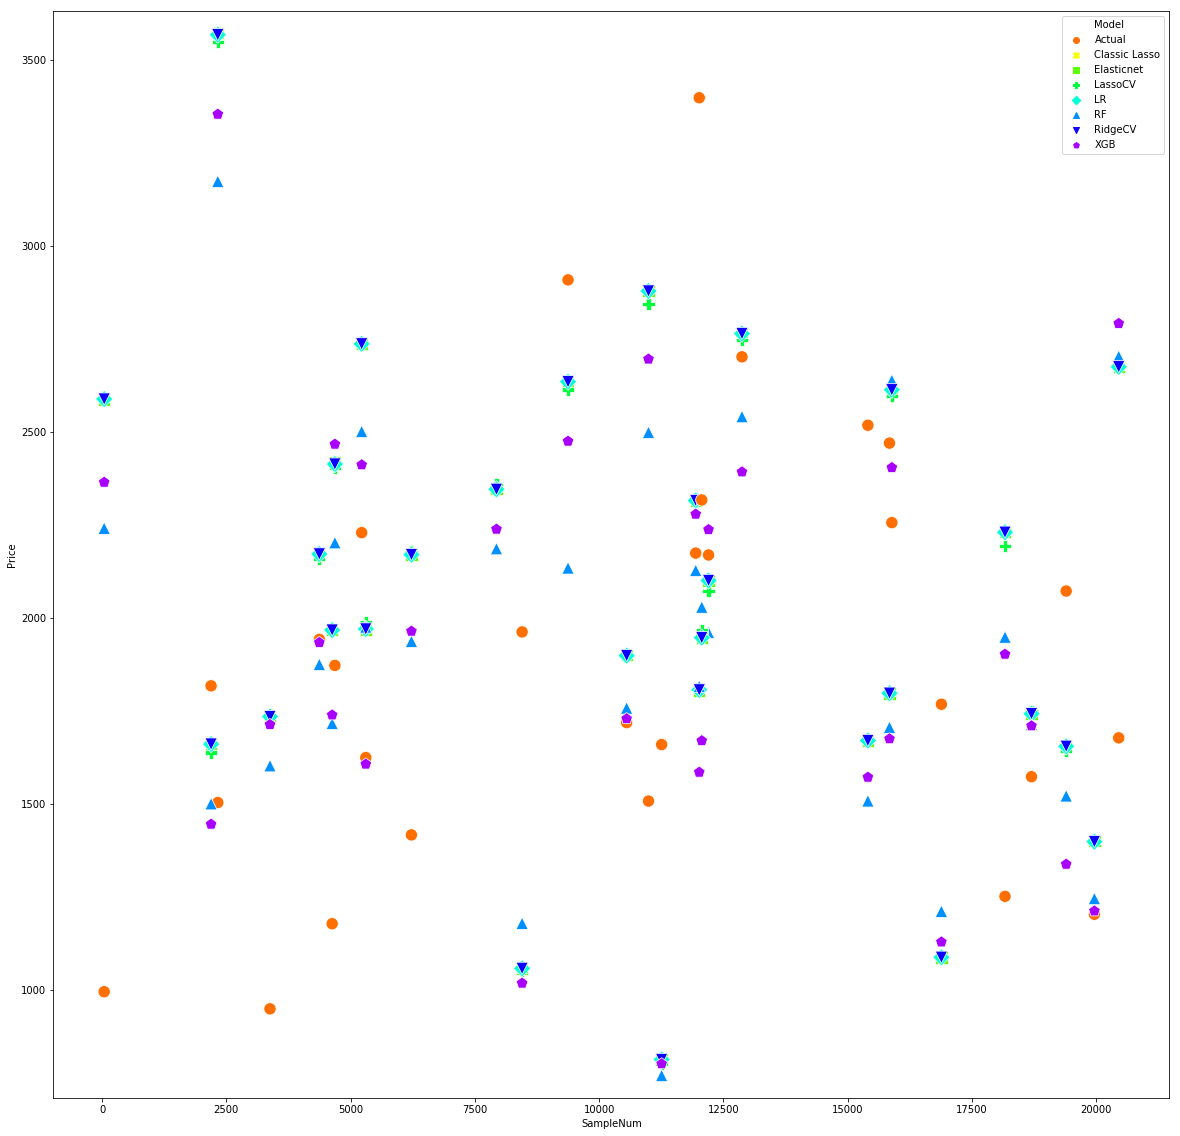

In [72]:
fig, ax = plt.subplots(figsize = (20, 20))

sns.scatterplot(x = "SampleNum", y = "Price", data = results1, hue = results1.Model, ax = ax, style = "Model", s = 150, palette = "gist_rainbow")
plt.legend(loc = "best")
plt.ylim(min(results1.Price)-60, max(results1.Price)+60)
plt.show()

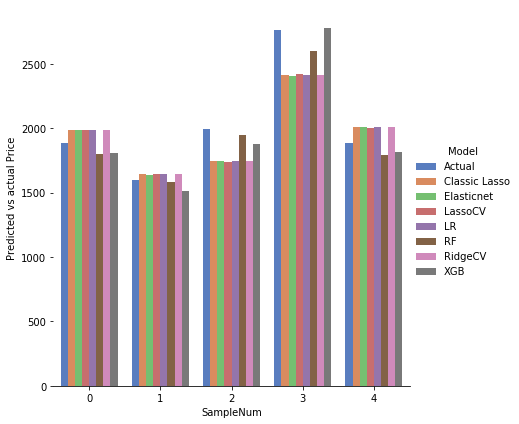

In [18]:
# fig, ax1 = plt.subplots(figsize = (12, 8))
g = sns.catplot(x = "SampleNum", y = "Price",hue = "Model",  data = results1, height=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("Predicted vs actual Price")

In [43]:
df_recs = pd.read_csv(os.path.join(dataFilePath, filename), low_memory= False)

In [63]:
totsqt = {0 : "df_recs.TOTHSQFT != -1",
             1 : "df_recs.TOTHSQFT < 900",
             2 : "df_recs.TOTHSQFT >= 900"}

In [58]:
print(totsqt[2])

df_recs.TOTHSQFT >= 900


In [64]:
df = df_recs[eval(totsqt[0])]
df.shape

(10, 196)